In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy
import pandas
import scipy
import scipy.stats


In [2]:
import os
import glob

os.chdir("C:\Users\colinsh\Box Sync\Winter 2015\IOE 513\IOE 513 Data")
os.listdir("./")
# Using os.listdir to show the output directory
os.listdir("output_reservoir")[0:5]

# Using glob to list the output directory
glob.glob("output_reservoir_screen/run-*")[0:5]

['output_reservoir_screen\\run-20150325-0',
 'output_reservoir_screen\\run-20150325-1',
 'output_reservoir_screen\\run-20150325-10',
 'output_reservoir_screen\\run-20150325-100',
 'output_reservoir_screen\\run-20150325-1000']

In [3]:
# Create "complete" data frames
run_data = []
all_timeseries_data = pandas.DataFrame()
all_interaction_data = pandas.DataFrame()


# Iterate over all directories
for run_directory in glob.glob("output_reservoir_screen/run*"):
    # Get the run ID from our directory name
    run_id = os.path.basename(run_directory)
    
    # Load parameter and reshape
    run_parameter_data = pandas.read_csv(os.path.join(run_directory, "parameters.csv"))
    run_parameter_data.index = run_parameter_data["parameter"]
    
    # Load timeseries and interactions
    run_interaction_data = pandas.read_csv(os.path.join(run_directory, "interactions.csv"))
    #run_interaction_data["run"] = run_id
    run_ts_data = pandas.read_csv(os.path.join(run_directory, "timeseries.csv"))
    #run_ts_data["run"] = run_id
    
    # Flatten parameter data into interaction and TS data
    for parameter_name in run_parameter_data.index:
        run_ts_data.loc[:, parameter_name] = run_parameter_data.loc[parameter_name, "value"]
     
    run_ts_data["run"] = run_id    
    
    if run_interaction_data.shape[0] > 0:
        for parameter_name in run_parameter_data.index:
            run_interaction_data.loc[:, parameter_name] = run_parameter_data.loc[parameter_name, "value"]
    
    run_interaction_data["run"] = run_id
    
    # Store raw run data
    run_data.append({"parameters": run_parameter_data,
                    "interactions": run_interaction_data,
                    "timeseries": run_ts_data})
    
    # Update final steps
    all_timeseries_data = all_timeseries_data.append(run_ts_data)
    all_interaction_data = all_interaction_data.append(run_interaction_data)

In [24]:
# Last time step 
last_step_data = all_timeseries_data.groupby("run").tail(1)
#print last_step_data.head()

# Max infected
max_infected_data = all_timeseries_data.groupby("run")["num_infected"].max()

# Max cities
max_cities_data = all_timeseries_data.groupby("run")["cities_infected"].max()

# Number of interactions
interactions_data = all_timeseries_data.groupby("run")["num_interactions"].sum()

In [4]:
# Store max infected across all parameter/runs
compiled_run_data = []

for run_id, run_data in all_timeseries_data.groupby("run"):
    # Isolate
    parameters = run_data.loc[0, ["reproduction_number", "screening_effectiveness", "reservoir", "throttle","initial_infected"]].to_dict()
    max_infected = run_data["num_infected"].max()
    max_infected_normalized = float(max_infected)/parameters["initial_infected"]
    max_cities = run_data["cities_infected"].max()
    interactions = run_data["num_interactions"].sum()
    compiled_run_data.append({"max_infected": max_infected,
                          "max_infected_normalized": max_infected_normalized,
                          "max_cities_infected": max_cities,
                          "num_interactions": interactions,
                          "reproduction_number": parameters["reproduction_number"],
                          "screening_effectiveness": parameters["screening_effectiveness"],
                          "reservoir": parameters["reservoir"],
                          "throttle": parameters["throttle"],
                          "initial_infected": parameters["initial_infected"]
                          })
    
compiled_df = pandas.DataFrame(compiled_run_data)


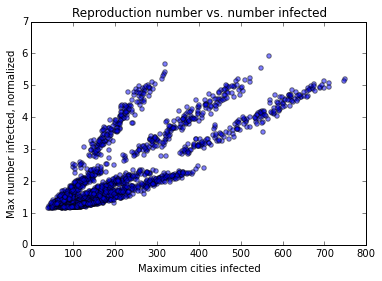

In [159]:
#%matplotlib inline

f = plt.figure()
plt.scatter(compiled_df.loc[(compiled_df["reservoir"]==1) & (compiled_df["reproduction_number"]<1),"num_interactions"],
           compiled_df.loc[(compiled_df["reservoir"]==1) & (compiled_df["reproduction_number"]<1),"max_infected_normalized"],
            alpha=0.5)
plt.xlabel("Maximum cities infected")
plt.ylabel("Max number infected, normalized")
plt.title("Reproduction number vs. number infected")



f=plt.figure()
plt.scatter(last_step_data["reproduction_number"],
           max_infected_data,
            alpha=0.5)

(5400, 15)


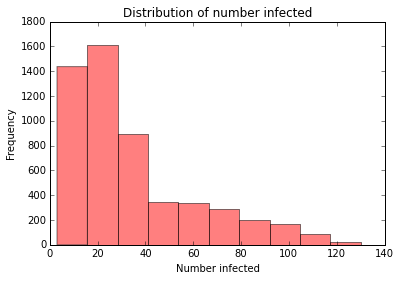

In [65]:
f# Plot a distribution
f = plt.figure()
_ = plt.hist(compiled_df["max_cities_infected"],
         color="red",
         alpha=0.5)
plt.xlabel("Number infected")
plt.ylabel("Frequency")
plt.title("Distribution of number infected")

print(last_step_data.shape)

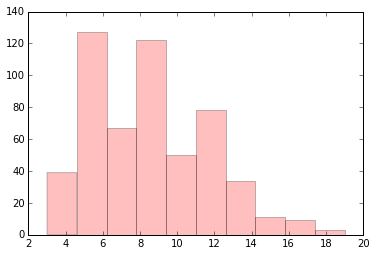

In [97]:
select_data = compiled_df.loc[(compiled_df["reservoir"] == 0) & (compiled_df["reproduction_number"]==.6),
                                     "max_cities_infected"]

f = plt.figure()
_ = plt.hist(select_data.values,
         color="red",
         alpha=0.25)


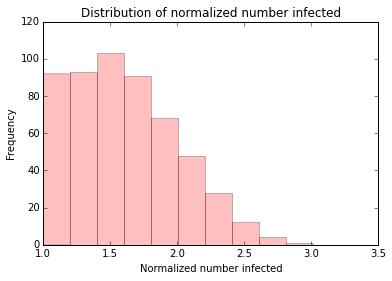

In [157]:
select_data = compiled_df.loc[(compiled_df["reservoir"] == 0) & (compiled_df["reproduction_number"]<1) & (compiled_df["reproduction_number"]>.8),
                                     "max_infected_normalized"]

f = plt.figure()
_ = plt.hist(select_data.values,
         color="red",
         alpha=0.25)
plt.xlabel("Normalized number infected")
plt.ylabel("Frequency")
plt.title("Distribution of normalized number infected")

In [32]:
# Want to see:
# effect of screening and throttling
# effect of reservoir

res_values=[0,1]
screening_values=[0,.3,.6]
throttle_values=[0,.2,.4]

for res in res_values:
    for screen in screening_values:
        for throttle in throttle_values:
            data=compiled_df.loc[(compiled_df["reservoir"] == res) & 
                                               (compiled_df["reproduction_number"]<1) & 
                                               (compiled_df["screening_effectiveness"]==screen) &
                                               (compiled_df["throttle"]==throttle)]
            
            
            f=plt.figure(figsize=(6.5,11.5))
            scat = f.add_subplot(411)
            infected = f.add_subplot(412)
            cities = f.add_subplot(413)
            interact = f.add_subplot(414)
            
            scat.scatter(data["max_cities_infected"],
                        data["max_infected_normalized"],
                        alpha=0.5)
            scat.set_xlabel("Maximum cities infected")
            scat.set_ylabel("Norm. max. infected")
            scat.set_title("Max. cities infected vs. Max. people infected")
            
        
            infected.hist(data["max_infected_normalized"].values,
                     color='red',
                     alpha=0.5)
            infected.set_xlabel("Normalized maximum infected")
            infected.set_ylabel("Frequency")
            infected.set_title("Distribution of normalized max. infected")

            cities.hist(data["max_cities_infected"].values,
                     color='red',
                     alpha=0.5)
            cities.set_xlabel("Maximum cities infected")
            cities.set_ylabel("Frequency")
            cities.set_title("Distribution of max. cities infected")   
            
            interact.hist(data["num_interactions"].values,
                     color='red',
                     alpha=0.5)
            interact.set_xlabel("Flights with infected passengers")
            interact.set_ylabel("Frequency")
            interact.set_title("Distribution of infected flights") 
            
            s_percent=int(screen*100)
            t_percent=int(throttle*100)
            plt.tight_layout()
            if res==0:
                f.suptitle("R<=0.9, screening_effectiveness={0}\nthrottling={1}, No Reservoir".format(s_percent,t_percent),fontsize=18)
            else:
                f.suptitle("R<=0.9, screening_effectiveness={0}\nthrottling={1}, Reservoir".format(s_percent,t_percent),fontsize=18)
            
            plt.subplots_adjust(top=.9)
            #save fig
            #make path
            output_path="data_vis"
            try:
                os.makedirs(output_path)
            except:
                pass
            #make unique name
            
            if res==0:
                run_id="no_res_s{0}_t{1}.png".format(s_percent,t_percent)
            else:
                run_id="res_s{0}_t{1}.png".format(s_percent,t_percent)
            
            run_output_path=os.path.join(output_path,run_id)
            plt.savefig(run_output_path)

In [164]:
int(0*100)

0

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
...
5385    0
5386    0
5387    0
5388    0
5389    0
5390    0
5391    0
5392    0
5393    0
5394    0
5395    0
5396    0
5397    0
5398    0
5399    0
Name: screening_effectiveness, Length: 5400, dtype: float64


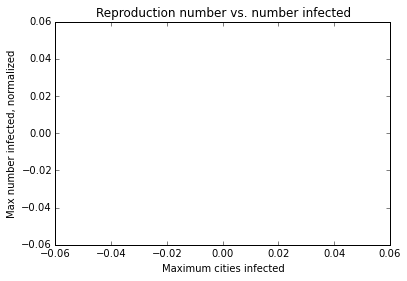

In [181]:
data=compiled_df.loc[(compiled_df["screening_effectiveness"]==.3)]
print compiled_df["screening_effectiveness"]
f = plt.figure()
plt.scatter(data["max_cities_infected"],
            data["max_infected_normalized"],
            alpha=0.5)
plt.xlabel("Maximum cities infected")
plt.ylabel("Max number infected, normalized")
plt.title("Reproduction number vs. number infected")

In [29]:
print "R=1, screening_effectiveness=0\nthrottling=1"

R=1, screening_effectiveness=0
throttling=1


In [33]:
print compiled_df["num_interactions"]

0      10
1      14
2       9
3       5
4      77
5      69
6      62
7      45
8      67
9      63
10     67
11     75
12    105
13     90
14     11
...
5385     80
5386     58
5387    107
5388    100
5389      9
5390     94
5391     85
5392     88
5393     81
5394    103
5395    104
5396     78
5397     72
5398     86
5399     75
Name: num_interactions, Length: 5400, dtype: int64
